In [2]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import PConvUNet2D
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec
from src.losses import calculate_metrics, warmup_loss
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple


complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

pandora_df = pd.read_csv("/hpc/home/srs108/TEMPO/pandora_filtered_data.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")



# train_ds.sample_vis(train=True)

In [9]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()

    def __init__(
        self,
        tif_dir,
        normalizer,
        file_list,
        train: bool,
        use_dataset_mask: bool = True,
        treat_zeros_as_missing: bool = False,
        valid_range=None,
        pandora_csv=None,
        time_tolerance="30min",
        # ---- temporal settings ----
        T: int = 8,                 # frames per window
        target_mode: str = "all",   # "all" or "last"
        max_time_gap: str = "2H",   # allowed gap between consecutive frames
        # ---- artificial mask settings (train only) ----
        artif_prob: float = 1.0,           # probability to apply artificial gaps to a sample
        n_blobs_range=(0, 4),              # per-slice number of blobs
        blob_size=(20, 74),                # per-slice blob sigma range (pixels)
        thr_range=(0.55, 0.85),            # threshold range for binary gaps
    ):
        self.tif_dir = tif_dir
        self.train = bool(train)
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # temporal configuration
        assert T >= 2 and T % 2 == 0 or T >= 3, "Use a reasonable T (e.g., 8 or 12)."
        self.T = int(T)
        self.pre = (self.T - 1) // 2
        self.post = self.T - self.pre - 1
        self.target_mode = str(target_mode).lower()
        assert self.target_mode in {"all", "last"}
        self.max_time_gap = pd.Timedelta(max_time_gap)

        # artificial masks
        self.artif_prob = float(artif_prob)
        self.n_blobs_range = n_blobs_range
        self.blob_size = blob_size
        self.thr_range = thr_range

        # store & index files by timestamp
        self.files = list(file_list)
        self.timestamps = [self._parse_time_from_fname(os.path.basename(p)) for p in self.files]
        order = np.argsort(np.array(self.timestamps, dtype="datetime64[ns]"))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

        # precompute valid centers that have a full T window with acceptable time gaps
        self.centers = self._build_centers()

        # -------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            df = pandora_csv.copy() if isinstance(pandora_csv, pd.DataFrame) else pd.read_csv(pandora_csv)
            if "datetime" not in df.columns or "NO2" not in df.columns:
                raise ValueError("Pandora CSV must contain 'datetime' and 'NO2'.")
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    # ---------- helpers ----------
    def _build_centers(self):
        """Find center indices i such that indices [i-pre, ..., i+post] exist and are temporally close."""
        centers = []
        N = len(self.files)
        for i in range(self.pre, N - self.post):
            ok = True
            # check consecutive gaps inside the window
            t_prev = self.timestamps[i - self.pre]
            for k in range(i - self.pre + 1, i + self.post + 1):
                t_curr = self.timestamps[k]
                if (t_curr - t_prev) > self.max_time_gap:
                    ok = False
                    break
                t_prev = t_curr
            if ok:
                centers.append(i)
        return centers

    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        fmts = ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d")
        for fmt in fmts:
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT

    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype="float64")
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- artificial gaps (per 2-D slice) ----------
    def _make_gaussian_blob_mask(self, H, W, keep_mask, rng):
        """Return a binary 'keep' mask (1=keep, 0=artificial hole) created by thresholding a smoothed noise field.
           Holes are only allowed where keep_mask==1 (i.e., on originally valid pixels)."""
        n_blobs = rng.integers(self.n_blobs_range[0], self.n_blobs_range[1] + 1)
        if n_blobs <= 0:
            return np.ones((H, W), dtype=np.float32)

        field = np.zeros((H, W), dtype=np.float32)
        for _ in range(n_blobs):
            noise = rng.standard_normal((H, W)).astype(np.float32)
            sigma = float(rng.uniform(self.blob_size[0], self.blob_size[1]))
            noise = scipy.ndimage.gaussian_filter(noise, sigma=sigma, mode="nearest")
            field += noise

        # normalize to [0,1]
        fmin, fmax = field.min(), field.max()
        s = (field - fmin) / (fmax - fmin + 1e-8)
        thr = float(rng.uniform(self.thr_range[0], self.thr_range[1]))
        holes = (s > thr).astype(np.float32)

        # forbid holes where original data is missing
        holes *= keep_mask.astype(np.float32)

        keep = 1.0 - holes  # 1=keep, 0=hole
        return keep

    # ---------- Pandora for a single path ----------
    def _pandora_for_path(self, path):
        with rasterio.open(path) as src:
            H, W = src.height, src.width
            tr, crs = src.transform, src.crs

        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()
            if not dfw.empty:
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    if {"lat", "lon"}.issubset(set(dfw.columns)):
                        xs = dfw["lon"].to_numpy(); ys = dfw["lat"].to_numpy()
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])
                    else:
                        rows = np.array([], dtype=int); cols = np.array([], dtype=int)

                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                dfw_ok = dfw.loc[ok].reset_index(drop=True)
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                if hasattr(self.normalizer, "normalize_pandora_array"):
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"):
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else:
                    vals_n = vals.astype(np.float32)

                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    station_names.append(station_names_raw[i] if i < len(station_names_raw) else f"Unknown_{i}")

        return pandora_mask, pandora_val_map, station_names

    def sample_vis(self, idx=None, max_cols=4, shp_path=shp_path, plot_pandora=True, seed=42):
        import math, re
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from datetime import datetime
        import rasterio
        from rasterio.transform import array_bounds

        rng = np.random.default_rng(seed)
        if idx is None:
            idx = rng.integers(len(self))
        sample = self[idx]

        # -------- helpers --------
        def _add_shape_and_pandora(ax, tr, crs, ts, segments, plot_pandora=True):
            """
            Draw shapefile lines and Pandora stations (categorical colors by station).
            Returns (has_pandora, legend_handles, shown_labels) so you can place a legend.
            """
            # ---- shapefile ----
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.6, zorder=3))

            has_pandora = False
            legend_handles = []
            shown_labels = []

            # ---- Pandora (categorical by station) ----
            if (plot_pandora and
                getattr(self, "pandora_df", None) is not None and
                ts is not pd.NaT and
                not self.pandora_df.empty and
                "station" in self.pandora_df.columns):

                # time-window filter
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()
                if dfw.empty:
                    return has_pandora, legend_handles, shown_labels

                # nearest per-station in time
                dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                # stable color per station (based on the full catalog)
                stations_all = (self.pandora_df["station"]
                                .dropna().astype(str).unique())
                palette = cm.tab20c(np.linspace(0, 1, max(1, len(stations_all))))
                station2color = dict(zip(stations_all, palette))

                # coordinates → row/col
                if {"row", "col"}.issubset(dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                elif {"lat", "lon"}.issubset(dfw.columns):
                    # lon/lat → col/row using the raster's transform
                    xs = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    ys = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(xs) & np.isfinite(ys) & (ys >= -90) & (ys <= 90)
                    dfw = dfw.loc[ok_ll].copy()
                    cols_rows = [~tr * (x, y) for x, y in zip(xs[ok_ll], ys[ok_ll])]
                    cols = np.array([int(round(c)) for c, r in cols_rows])
                    rows = np.array([int(round(r)) for c, r in cols_rows])
                else:
                    return has_pandora, legend_handles, shown_labels

                # keep only inside image
                H, W = int(ax.images[0].get_array().shape[0]), int(ax.images[0].get_array().shape[1])
                ok_in = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                if ok_in.sum() == 0:
                    return has_pandora, legend_handles, shown_labels

                rows, cols = rows[ok_in], cols[ok_in]
                labels = dfw.loc[ok_in, "station"].astype(str).to_numpy()

                # row/col → x/y for plotting in map coords
                xs, ys = _rowcol_to_xy_vec(rows, cols, tr)

                # plot (white halo + colored diamond per station)
                has_pandora = True
                ax.scatter(xs, ys, s=110, marker='D', facecolor='white',
                           edgecolor='none', zorder=7)
                for x, y, lab in zip(xs, ys, labels):
                    c = station2color.get(lab, (0.2, 0.2, 0.2, 1.0))
                    ax.scatter(x, y, s=80, marker='D', facecolor=c,
                               edgecolor='k', linewidth=0.8, zorder=8)

                # legend handles (one per unique label actually shown)
                for lab in np.unique(labels):
                    c = station2color.get(lab, (0.2, 0.2, 0.2, 1.0))
                    proxy = Line2D([0], [0], marker='D', color='none',
                                   markerfacecolor=c, markeredgecolor='k',
                                   markeredgewidth=0.8, markersize=9, label=lab)
                    legend_handles.append(proxy)
                shown_labels = list(np.unique(labels))

            return has_pandora, legend_handles, shown_labels

        def get_any(keys, default=None, required=False):
            for k in keys:
                if k in sample and sample[k] is not None:
                    return sample[k]
            if required:
                raise KeyError(f"None of keys {keys} found in sample. Available: {list(sample.keys())}")
            return default

        def to_THW(x):
            """Accepts 2D/3D/4D, returns [T,H,W]."""
            if x is None:
                return None
            a = x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)
            if a.ndim == 2:                 # [H,W]
                return a[None, ...]         # [1,H,W]
            if a.ndim == 3:                 # [T,H,W] or [C,H,W]
                return a                    # assume T==first dim
            if a.ndim == 4:                 # [1,T,H,W] or [T,1,H,W]
                if a.shape[0] == 1:         # [1,T,H,W] -> [T,H,W]
                    return a[0]
                if a.shape[1] == 1:         # [T,1,H,W] -> [T,H,W]
                    return a[:,0]
            raise ValueError(f"Expected 2D/3D/4D array, got shape {a.shape}")

        # -------- fetch arrays (robust key mapping) --------
        img_in   = to_THW(get_any(["masked_img", "img_in"], required=True))
        target   = to_THW(get_any(["target"], required=True))
        mask_real= to_THW(get_any(["mask_real","mask_known","mask_observed","mask_dataset","mask_orig"], required=True)) # 1=valid
        mask_aug = to_THW(get_any(["mask_aug","mask_gauss","fake_mask","mask_sp","mask_art"], required=False))           # 1=kept
        mask_eff = to_THW(get_any(["mask_in","mask_effective","known_and_fake_mask"], required=False))                  # effective

        # paths/timestamps per time step (optional)
        paths_t  = get_any(["path_t","paths","path_list"], default=None)
        if paths_t is None:
            p = get_any(["path"], required=True)
            paths_t = [p] * img_in.shape[0]
        ts_list  = get_any(["ts_t","timestamps","ts_list"], default=None)

        T, H, W = target.shape

        # -------- color scale from target --------
        finite_all = np.isfinite(target)
        if finite_all.any():
            vmin, vmax = np.percentile(target[finite_all], [2, 98])
        else:
            vmin, vmax = 0.0, 1.0
        cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

        # shapefile segments & reference geo from first path
        segments = []
        ref_tr = ref_crs = None
        if shp_path is not None and len(paths_t) > 0:
            with rasterio.open(paths_t[0]) as src0:
                ref_tr, ref_crs = src0.transform, src0.crs
            try:
                segments = load_shapefile_segments_pyshp(shp_path, ref_crs)
            except Exception:
                segments = []

        # layout
        ncols = min(max_cols, T)
        nrows = math.ceil(T / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(5.3*ncols, 4.8*nrows), squeeze=False)

        legend_handles_all = None
        used_any_stations = False

        for t in range(T):
            r, c = t // ncols, t % ncols
            ax = axes[r, c]

            path_t = paths_t[t] if t < len(paths_t) else paths_t[0]
            with rasterio.open(path_t) as src:
                tr, crs = src.transform, src.crs
                xmin, ymin, xmax, ymax = array_bounds(src.height, src.width, tr)

            # timestamp label
            if ts_list is not None and t < len(ts_list) and isinstance(ts_list[t], pd.Timestamp):
                ts = ts_list[t]
                dt_label = ts.strftime("%Y-%m-%d %H:%M:%S")
            else:
                base = re.sub(r"\D", "", str(path_t))[:14]
                try:
                    ts = pd.to_datetime(base, format="%Y%m%d%H%M%S", errors="coerce")
                    dt_label = ts.strftime("%Y-%m-%d %H:%M:%S") if pd.notna(ts) else str(path_t)
                except Exception:
                    ts = pd.NaT
                    dt_label = str(path_t)

            # effective mask to whiten holes
            if mask_eff is not None:
                eff = mask_eff[t].astype(bool)
            else:
                real_valid = mask_real[t].astype(bool)
                aug_keep   = mask_aug[t].astype(bool) if mask_aug is not None else np.ones((H,W), bool)
                eff = real_valid & aug_keep

            # base image
            ax_img = ax.imshow(np.ma.array(img_in[t], mask=~eff),
                               cmap=cmap_v, vmin=vmin, vmax=vmax,
                               extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=1)

            # overlays
            real_holes = (mask_real[t] == 0)
            ax.imshow(real_holes, cmap="Reds", alpha=0.35,
                      extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=3)
#             if mask_aug is not None:
#                 art_holes = (mask_aug[t] == 0)
#                 ax.imshow(art_holes, cmap="Blues", alpha=0.35,
#                           extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=3)

            # shapefile + Pandora (your helper should handle styling and return legend handles)\
            has_pandora, legend_handles, shown_labels = _add_shape_and_pandora(ax, tr, crs, ts, segments, plot_pandora=plot_pandora)
            if has_pandora and not used_any_stations and legend_handles:
                legend_handles_all = legend_handles
                used_any_stations = True

            ax.set_title(f"t={t}  {dt_label}", fontsize=11)
            ax.set_aspect('equal')
            ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
            ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

            # stash first image handle for colorbar
            if t == 0:
                first_im = ax_img

        # hide empties
        for k in range(T, nrows*ncols):
            r, c = k // ncols, k % ncols
            axes[r, c].axis("off")

        # single colorbar
        if 'first_im' in locals():
            cbar = fig.colorbar(first_im, ax=axes, fraction=0.025, pad=0.02)
            cbar.set_label("Value", rotation=90)

        # station legend on first axis if available
        if used_any_stations and legend_handles_all:
            axes[0,0].legend(handles=legend_handles_all,
                             bbox_to_anchor=(-0.85, 1.0), loc="upper left",
                             frameon=True, fontsize=11, markerscale=1.2,
                             title="Pandora Stations")

        plt.show()


    def __len__(self):
        return len(self.centers)

    def __getitem__(self, idx):
        center_idx = self.centers[idx]
        idxs = list(range(center_idx - self.pre, center_idx + self.post + 1))
        paths = [self.files[i] for i in idxs]
        ts_list = [self.timestamps[i] for i in idxs]

        # read stack
        imgs = []
        m_known = []
        H = W = None
        for p in paths:
            arr_valid, known_mask = self._read_band_masked(p)
            arr = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
            if H is None:
                H, W = arr.shape
            imgs.append(self.normalizer.normalize_image(arr))
            m_known.append(known_mask.astype(np.float32))
        imgs = np.stack(imgs, axis=0)        # [T,H,W]
        m_known = np.stack(m_known, axis=0)  # [T,H,W]

        # artificial masks (train only)
        rng = np.random.default_rng()
        if self.train and (rng.random() < self.artif_prob):
            m_fake = []
            for t in range(self.T):
                keep_mask_t = m_known[t]  # only create holes where data is originally valid
                keep_t = self._make_gaussian_blob_mask(H, W, keep_mask_t, rng)
                m_fake.append(keep_t.astype(np.float32))
            m_fake = np.stack(m_fake, axis=0)  # [T,H,W], 1=keep, 0=artificial hole
        else:
            m_fake = np.ones_like(m_known, dtype=np.float32)

        # effective training mask
        m_eff = m_known * m_fake  # 1=keep, 0=hole

        # input with holes
        x_masked = imgs * m_eff

        # target
        if self.target_mode == "all":
            target = imgs  # [T,H,W]
        else:  # "last"
            target = imgs[None, -1, :, :]      # [1,H,W]
            x_masked = x_masked                # [T,H,W] input still uses full window
            m_eff = m_eff

        # add channel dim → [1,T,H,W] (or [1,1,H,W] for last target)
        x = torch.from_numpy(x_masked).unsqueeze(0).float()
        m_in = torch.from_numpy(m_eff).unsqueeze(0).float()
        m_known_t = torch.from_numpy(m_known).unsqueeze(0).float()
        m_fake_t = torch.from_numpy(m_fake).unsqueeze(0).float()
        if self.target_mode == "all":
            y = torch.from_numpy(target).unsqueeze(0).float()          # [1,T,H,W]
        else:
            y = torch.from_numpy(target).unsqueeze(0).float()          # [1,1,H,W]

        # Pandora (center slice only)
        center_path = paths[self.pre]
        p_mask, p_val_map, station_names = self._pandora_for_path(center_path)

        sample = {
            "img_in": x,                 # [1,T,H,W]
            "mask_in": m_in,             # [1,T,H,W]
            "mask_known": m_known_t,     # [1,T,H,W]
            "mask_fake": m_fake_t,       # [1,T,H,W]
            "target": y,                 # [1,T,H,W] or [1,1,H,W]
            "paths": paths,
            "center_path": center_path,
            "timestamps": ts_list,
            "p_mask": torch.from_numpy(p_mask),
            "p_val_mask": torch.from_numpy(p_val_map),
            "station_names": station_names,
        }
        return sample

    

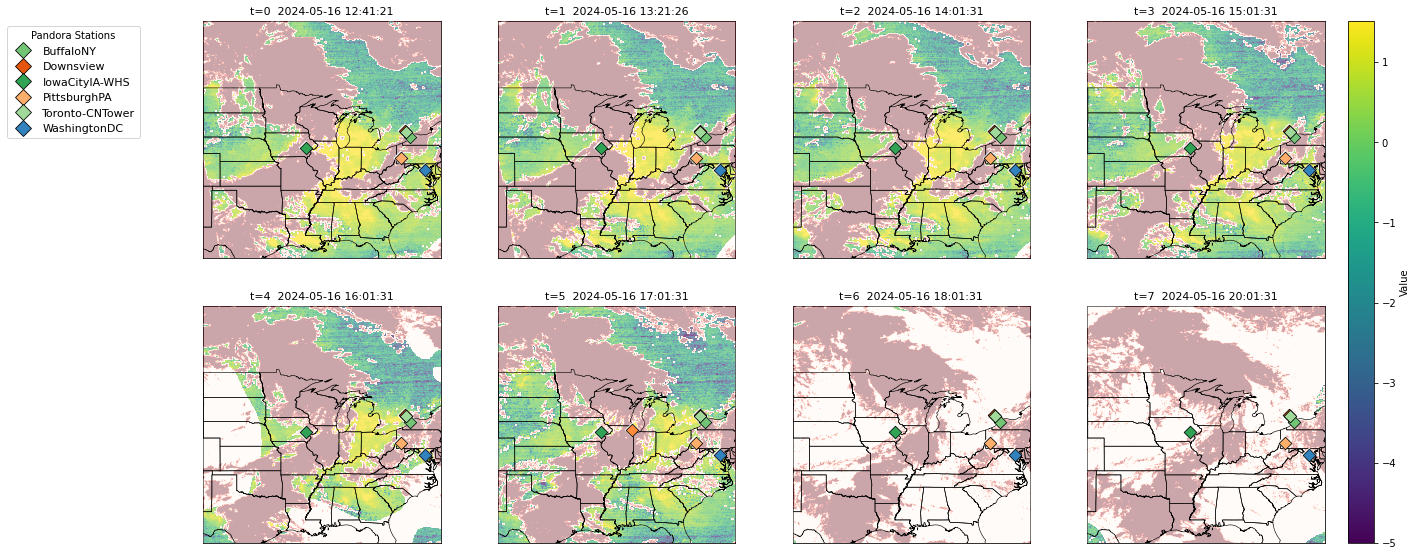

In [10]:
train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
train_ds.sample_vis()

In [18]:
import math
from typing import Iterable, List, Optional, Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------------
# 3D Partial Convolution layer
# -------------------------------
class STPConv3d(nn.Module):
    """
    SpatioTemporal Partial Convolution (3D).
    Inputs:
      - img:  [B, Cin,  D, H, W]
      - mask: [B, 1,    D, H, W]  (1=known, 0=hole)
    Returns:
      - feat: [B, Cout, D', H', W']
      - mout: [B, 1,    D', H', W']  (propagated binary mask)
    Behavior mirrors the TensorFlow STpconv: masked conv + valid-ratio normalization.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] = (3, 3, 3),
        stride: Sequence[int] = (1, 1, 1),
        bias: bool = True,
        activation: Optional[nn.Module] = None,
    ):
        super().__init__()
        kz = kernel_size if isinstance(kernel_size, Iterable) else (kernel_size,) * 3
        st = stride if isinstance(stride, Iterable) else (stride,) * 3
        pad = tuple(k // 2 for k in kz)  # "same" padding

        self.conv = nn.Conv3d(
            in_channels, out_channels,
            kernel_size=kz, stride=st, padding=pad, bias=bias
        )

        # single-channel mask kernel of ones for counting valids
        self.register_buffer(
            "mask_kernel",
            torch.ones(1, 1, kz[0], kz[1], kz[2])
        )
        self.stride = st
        self.padding = pad
        self.kernel_numel = kz[0] * kz[1] * kz[2]
        self.activation = activation if activation is not None else nn.Identity()

    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Ensure mask is 1-channel and broadcastable
        if mask.shape[1] != 1:
            mask = mask[:, :1, ...]

        # 1) Mask image
        x = img * mask

        # 2) Convolve image
        y = self.conv(x)

        # 3) Convolve mask with ones to count valid pixels in each window
        with torch.no_grad():
            m_count = F.conv3d(
                mask, self.mask_kernel,
                stride=self.stride, padding=self.padding
            )
            m_bin = (m_count > 0).float()  # clip to 0/1 like TF code

        # 4) Normalize by valid ratio (like TF: n / count * bin)
        # broadcast to output channels
        mask_ratio = (self.kernel_numel / (m_count + 1e-8)) * m_bin
        y = y * mask_ratio

        # 5) Activation
        y = self.activation(y)

        # Output mask is binary
        return y, m_bin


# -------------------------------
# Spatiotemporal PConv U-Net (3D)
# -------------------------------
class STPConvUNet3D(nn.Module):
    """
    PyTorch port of the TensorFlow STpconvUnet.
    Args mirror the TF version (except we don't 'compile'—use your own optimizer/loss).
    """
    def __init__(
        self,
        in_ch: int = 1,
        out_ch: int = 1,
        n_conv_layers: int = 4,
        nx: int = 128, ny: int = 128, nt: int = 16,     # used only to auto-derive strides when not given
        kernel_sizes: Optional[List[Tuple[int,int,int]]] = None,
        n_filters: Optional[List[int]] = None,
        strides: Optional[List[Tuple[int,int,int]]] = None,
        n_conv_per_block: int = 1,
        leaky: float = 0.1,
    ):
        super().__init__()
        assert n_conv_layers > 1, "n_conv_layers must be > 1"
        self.n_conv_layers = n_conv_layers
        self.n_conv_per_block = n_conv_per_block
        act = nn.LeakyReLU(leaky, inplace=True)

        # ----- derive defaults to match TF code -----
        if strides is None:
            strides = []
            for i in range(n_conv_layers):
                sD = 2 if nt / (2 ** (i + 1)) >= 1 else 1
                sH = 2 if ny / (2 ** (i + 1)) >= 1 else 1
                sW = 2 if nx / (2 ** (i + 1)) >= 1 else 1
                strides.append((sD, sH, sW))
        else:
            assert len(strides) == n_conv_layers

        if kernel_sizes is None:
            kernel_sizes = [(3, 3, 3)] * n_conv_layers
        else:
            assert len(kernel_sizes) == n_conv_layers

        if n_filters is None:
            n_filters = [min(2 ** (i + 5), 256) for i in range(n_conv_layers)]
        else:
            assert len(n_filters) == n_conv_layers

        # ----- ENCODER -----
        enc_layers = nn.ModuleList()
        c_in = in_ch
        for i in range(n_conv_layers):
            c_out = n_filters[i]
            kz = kernel_sizes[i]
            st = strides[i]
            block = self._make_pconv_block(
                c_in, c_out, kz, st, n_conv_per_block, act
            )
            enc_layers.append(block)
            c_in = c_out
        self.encoder = enc_layers

        # bottleneck = last encoder output (already built into encoder)

        # ----- DECODER -----
        dec_layers = nn.ModuleList()
        upsamplers = nn.ModuleList()
        # We upsample by the same factor we downsampled
        for i in reversed(range(n_conv_layers)):
            # upsample to match the skip coming from encoder i-1 (or the original input for i==0)
            size = strides[i]  # scale_factor for D,H,W
            upsamplers.append(Upsample3D(size))

            if i == 0:
                # final decoder fusion goes to out_ch
                c_out = out_ch
            else:
                c_out = n_filters[i-1]

            # input channels = skip channels + current upsampled channels
            c_skip = in_ch if i == 0 else n_filters[i-1]
            c_up   = n_filters[i]
            c_cat  = c_skip + c_up

            # TF decoder uses 3x3x3 kernels only, stride=1 in decoder
            block = self._make_pconv_block(
                c_cat, c_out, (3,3,3), (1,1,1),
                # In TF they do: one PConv without activation, then (n-1) with LeakyReLU.
                # Here we mirror: first op has no activation only if n_conv_per_block>1? We'll keep all with act for stability.
                n_conv_per_block, act
            )
            dec_layers.append(block)

        self.decoders = dec_layers
        self.upsamplers = upsamplers

        # Final 1x1x1 linear conv (only if last decoder didn't already output out_ch)
        # Keep explicit to mirror TF Conv3D(1,1) linear.
        if n_conv_per_block > 0 and dec_layers[0][-1].conv.out_channels != out_ch:
            self.head = nn.Conv3d(dec_layers[0][-1].conv.out_channels, out_ch, kernel_size=1)
        else:
            self.head = nn.Identity()

    def _make_pconv_block(
        self,
        in_ch: int,
        out_ch: int,
        kernel_size: Tuple[int,int,int],
        stride: Tuple[int,int,int],
        n_conv: int,
        act: nn.Module,
    ) -> nn.Sequential:
        """
        Builds one encoder/decoder block:
          - if n_conv > 1: (n_conv-1) × stride=1, then 1 × stride=stride
          - else: single STPConv3d with given stride
        """
        layers = []
        if n_conv > 1:
            # (n_conv-1) stride=1
            c_in = in_ch
            for _ in range(n_conv - 1):
                layers.append(STPConv3d(c_in, out_ch, kernel_size, (1,1,1), bias=True, activation=act))
                c_in = out_ch
            # final with the requested stride
            layers.append(STPConv3d(out_ch, out_ch, kernel_size, stride, bias=True, activation=act))
        else:
            layers.append(STPConv3d(in_ch, out_ch, kernel_size, stride, bias=True, activation=act))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, m: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        x: [B, C, T, H, W], m: [B, 1, T, H, W]
        """
        enc_feats: List[torch.Tensor] = []
        enc_masks: List[torch.Tensor] = []

        feat, mask = x, m
        # ----- Encoder -----
        for block in self.encoder:
            for layer in block:
                feat, mask = layer(feat, mask)
            enc_feats.append(feat)
            enc_masks.append(mask)

        # ----- Decoder -----
        y, ym = enc_feats[-1], enc_masks[-1]
        dec_idx = 0
        for i in reversed(range(self.n_conv_layers)):
            # upsample current features & mask
            up = self.upsamplers[dec_idx]
            y_up = up(y)
            m_up = up(ym)

            # pick skip (encoder i-1 or input for i==0)
            if i == 0:
                skip_f = x
                skip_m = m
            else:
                skip_f = enc_feats[i-1]
                skip_m = enc_masks[i-1]

            # concatenate along channels
            y_cat = torch.cat([skip_f, y_up], dim=1)
            m_cat = torch.cat([skip_m, m_up], dim=1)  # Note: STPConv3d expects mask with 1 channel; we pass the first

            # reduce mask to single channel for the next PConv block
            # (take "any valid" across channels)
            m1 = (m_cat.sum(dim=1, keepdim=True) > 0).float()

            # pass through decoder block
            block = self.decoders[dec_idx]
            feat, mask_out = y_cat, m1
            for layer in block:
                feat, mask_out = layer(feat, mask_out)

            y, ym = feat, mask_out
            dec_idx += 1

        y = self.head(y)
        return y, ym


# -------------------------------
# Simple nearest-neighbor 3D upsample with integer factors
# -------------------------------
class Upsample3D(nn.Module):
    def __init__(self, scale_factors: Tuple[int,int,int]):
        super().__init__()
        self.scale = scale_factors

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # F.interpolate expects scale_factor in order (D, H, W)
        return F.interpolate(x, scale_factor=self.scale, mode="nearest")


In [13]:
def mae_masked(pred, target, mask1):
    # mask1: 1 = include in loss
    num = (mask1 > 0.5).sum().clamp_min(1)
    return (torch.abs(pred - target) * mask1).sum() / num

def rmse_masked(pred, target, mask1):
    num = (mask1 > 0.5).sum().clamp_min(1)
    return torch.sqrt(((pred - target)**2 * mask1).sum() / num)

def r2_masked(pred, target, mask1, eps=1e-8):
    y = target[mask1 > 0.5]
    yhat = pred[mask1 > 0.5]
    if y.numel() == 0:
        return torch.tensor(0.0, device=pred.device)
    ss_res = torch.sum((y - yhat)**2)
    ss_tot = torch.sum((y - y.mean())**2) + eps
    return 1.0 - ss_res / ss_tot


In [14]:
def train_model_3d(model, train_loader, val_loader, epochs=50, patience=10, lr=1e-4, csv_path="history_3d.csv"):
    device = next(model.parameters()).device
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss = float("inf")
    best_state = None
    wait = 0
    history = []

    for epoch in range(epochs):
        # ------------------------ TRAIN ------------------------
        model.train()
        tr_loss = 0.0
        tr_mae = tr_rmse = tr_r2 = 0.0
        tr_batches = 0

        for batch in train_loader:
            x      = batch["masked_seq"].to(device)     # [B,1,T,H,W]
            m_eff  = batch["mask_eff"].to(device)       # passed into model
            m_real = batch["mask_real"].to(device)      # instrument known
            m_aug  = batch.get("mask_aug", None)
            y      = batch["target_seq"].to(device)

            # (1) forward with effective mask (real * aug_keep)
            pred, _ = model(x, m_eff)

            # (2) TRAIN LOSS: MAE **only on artificial gaps**
            # gap_mask = pixels that were originally known but were hidden by augmentation:
            # gap_mask = m_real * (1 - m_aug)
            if m_aug is None:
                # If dataset didn’t supply aug mask (shouldn’t happen in training), fall back
                gap_mask = (m_real * (1 - m_eff)).clamp(min=0)
            else:
                m_aug = m_aug.to(device)
                gap_mask = (m_real * (1.0 - m_aug)).clamp(min=0)

            loss = mae_masked(pred, y, gap_mask)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_loss += loss.item()
            tr_mae  += mae_masked(pred, y, gap_mask).item()
            tr_rmse += rmse_masked(pred, y, gap_mask).item()
            tr_r2   += r2_masked(pred, y, gap_mask).item()
            tr_batches += 1

        tr_loss /= max(tr_batches, 1)
        tr_mae  /= max(tr_batches, 1)
        tr_rmse /= max(tr_batches, 1)
        tr_r2   /= max(tr_batches, 1)

        # ------------------------ VALIDATION ------------------------
        model.eval()
        va_loss = 0.0
        va_mae = va_rmse = va_r2 = 0.0
        va_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                x      = batch["masked_seq"].to(device)
                m_real = batch["mask_real"].to(device)   # at val we usually don’t add aug gaps
                y      = batch["target_seq"].to(device)

                # forward with *real* mask at validation
                pred, _ = model(x, m_real)

                # VAL LOSS: MAE on all observed pixels (instrument-known)
                loss = mae_masked(pred, y, m_real)

                va_loss += loss.item()
                va_mae  += mae_masked(pred, y, m_real).item()
                va_rmse += rmse_masked(pred, y, m_real).item()
                va_r2   += r2_masked(pred, y, m_real).item()
                va_batches += 1

        va_loss /= max(va_batches, 1)
        va_mae  /= max(va_batches, 1)
        va_rmse /= max(va_batches, 1)
        va_r2   /= max(va_batches, 1)

        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | "
              f"MAE(gaps): {tr_mae:.4f} | RMSE(gaps): {tr_rmse:.4f} | R²(gaps): {tr_r2:.3f} | "
              f"Val MAE(all-known): {va_mae:.4f}")

        # ------------------------ EARLY STOPPING ------------------------
        if va_loss < best_loss - 1e-6:
            best_loss = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # ------------------------ LOG TO CSV ------------------------
        history.append({
            "epoch": epoch+1,
            "train_loss": tr_loss,
            "val_loss": va_loss,
            "train_mae_gaps": tr_mae,
            "train_rmse_gaps": tr_rmse,
            "train_r2_gaps": tr_r2,
            "val_mae_known": va_mae,
            "val_rmse_known": va_rmse,
            "val_r2_known": va_r2
        })
        try:
            import csv
            with open(csv_path, "w", newline="") as f:
                writer = csv.DictWriter(f, fieldnames=list(history[0].keys()))
                writer.writeheader()
                writer.writerows(history)
        except Exception:
            pass

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)
    return model, history


In [19]:
model = STPConvUNet3D(
    in_ch=1, out_ch=1,
    n_conv_layers=4,
    nx=400, ny=400, nt=8,          # only used to auto-derive strides if not provided
    n_conv_per_block=2             # like your TF option
)

x = torch.randn(2, 1, 8, 400, 400)   # [B,C,T,H,W]
m = torch.ones(2, 1, 8, 400, 400)    # binary mask

y, m_out = model(x, m)
print(y.shape, m_out.shape)          # => [2,1,8,400,400], [2,1,8,400,400]


RuntimeError: Given groups=1, weight of size [1, 128, 1, 1, 1], expected input[2, 1, 8, 400, 400] to have 128 channels, but got 1 channels instead

In [15]:
# model: your ST-pconv U-Net 3D on CUDA
model = STPConvUNet3D(in_ch=1, out_ch=1, base_ch=32, depth=5, ...).cuda()

# train_loader/val_loader must return the keys described above with 5-D tensors
model, hist = train_model_3d(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    patience=15,
    lr=1e-4,
    csv_path="stpconv3d_history.csv"
)


SyntaxError: positional argument follows keyword argument (<ipython-input-15-8d2f870bfa30>, line 2)